## BERT Classifier for Software & Hardware Jira Tickets
- PRTSIR = Hardware = 1
- ICT = Software = 0

In [3]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

In [1]:
#import libraries
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import keras
from tqdm import tqdm
import pickle
from keras.models import Model
import keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import itertools
from keras.models import load_model
from sklearn.utils import shuffle
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
import tensorflow_text as text

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

#hide warnings
import warnings
warnings.filterwarnings('ignore')


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

/home/dataiku/dss_data/code-envs/python/mypython/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dataiku/dss_data/code-envs/python/mypython/lib/python3.7/site-packages/transformers/generation_utils.py:27: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  FutureWarning,
/home/dataiku/dss_data/code-envs/python/mypython/lib/python3.7/site-packages/transformers/generation_tf_utils.py:27: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  FutureWarning,


In [4]:
# Read recipe inputs
# Dataset pharmacy_dataset_reduced renamed to pharmacy_dataset_TEST by vkb6bn on 2023-03-08 17:42:52
data = dataiku.Dataset("PRTSIR_Antenna_stacked")
data = data.get_dataframe()
len(data)

/home/dataiku/dss_data/code-envs/python/mypython/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


692

In [5]:
data.head()

,key,text,label
0,PRTSIR-15676,e2e7 test observe delay offset 0.28nsec polari...,1
1,PRTSIR-2184,run sb dv15 go error brake engage mapping ioni...,1
2,PRTSIR-5907,sbex focus sbs version --fail-- start end proj...,1
3,PRTSIR-8622,run spatially resolve co excitation lensed nor...,1
4,PRTSIR-1609,try delaycal antenna bl correlator errors mess...,1


In [6]:
#drop any missing values
data = data.dropna()
#reset index
data=data.reset_index(drop=True) 
#shuffle data
data = shuffle(data)   
data.head(3)

,key,text,label
381,PRTSIR-8628,"run noformat sbex"",""2016 01t12:00:31 01t12:01:...",1
664,PRTSIR-14099,dv22 lose cppcontainer not reach abm mannager ...,0
257,PRTSIR-4657,try run sbex focus sbs bl corr version --fail-...,1


In [7]:
#define the number of unique classes under 'label'
num_classes=len(data.label.unique())
num_classes

2

In [8]:
#define y variable
y = tf.keras.utils.to_categorical(data["label"].values, num_classes=num_classes)
#y

#split data into test and train
x_train, x_test, y_train, y_test = train_test_split(data['text'], y, test_size=0.3)
len(x_train), len(x_test), len(y_train), len(y_test)

(484, 208, 484, 208)

In [9]:
#load bert with tensorflow hub
preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

#function to get word embeddings
def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']

#test function
#get_embeddings([
   # "This is a test para ver el futuro of the model."])

In [10]:
#resource: https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d#98ee
from keras import backend as K

#functions to find recall
def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

#functions to find precision
def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

#functions to find f1 score
def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [11]:
#define model
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

bert_model = tf.keras.Model(i, x)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [26]:
#define number of epochs
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      tf.keras.metrics.TrueNegatives(),
      tf.keras.metrics.FalsePositives(),
      tf.keras.metrics.AUC(),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

#EarlyStopping callback to monitor validation loss
#if metric doesn't improve for at least 3 epochs (patience = 3)
    #training is interrupted and weights from epoch where the validation loss 
    #showed the best value (i.e. lowest) are restored (restore_best_weights = True)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)


In [27]:
#compile model
bert_model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

In [28]:
#fit model
model_fit = bert_model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback], verbose=1)

Epoch 1/20
16/16 [==============================] - 77s 5s/step - loss: 0.3760 - accuracy: 0.8285 - true_negatives_1: 401.0000 - false_positives_1: 83.0000 - auc_1: 0.9279 - balanced_recall: 0.7706 - balanced_precision: 0.8099 - balanced_f1_score: 0.7883 - val_loss: 0.3962 - val_accuracy: 0.8317 - val_true_negatives_1: 173.0000 - val_false_positives_1: 35.0000 - val_auc_1: 0.9107 - val_balanced_recall: 0.7681 - val_balanced_precision: 0.8684 - val_balanced_f1_score: 0.8146
Epoch 2/20
16/16 [==============================] - 72s 5s/step - loss: 0.3792 - accuracy: 0.8223 - true_negatives_1: 398.0000 - false_positives_1: 86.0000 - auc_1: 0.9180 - balanced_recall: 0.7438 - balanced_precision: 0.8013 - balanced_f1_score: 0.7686 - val_loss: 0.3939 - val_accuracy: 0.8462 - val_true_negatives_1: 176.0000 - val_false_positives_1: 32.0000 - val_auc_1: 0.9241 - val_balanced_recall: 0.8083 - val_balanced_precision: 0.8461 - val_balanced_f1_score: 0.8261
Epoch 3/20
16/16 [==========================

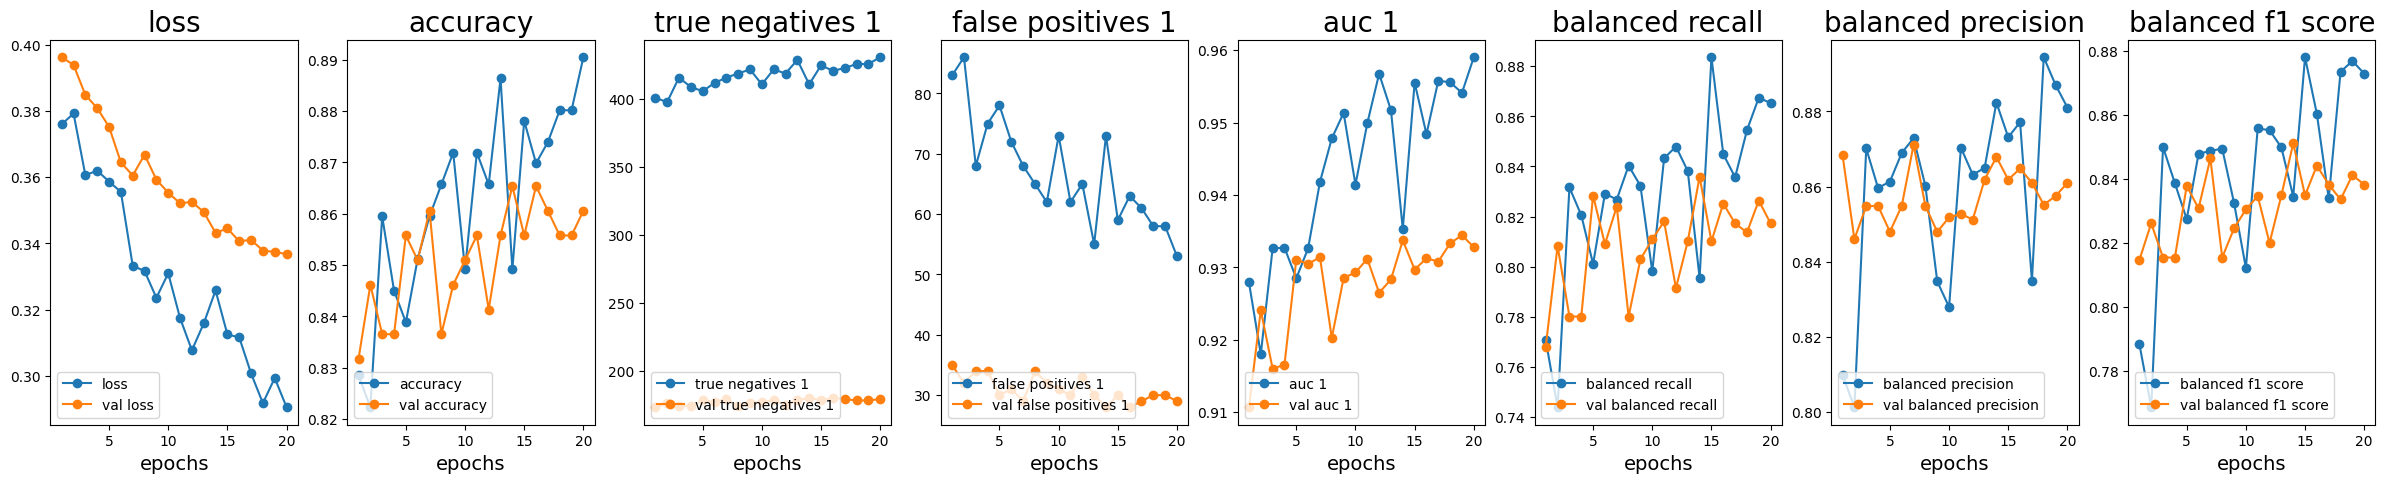

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [30]:
model_fit.history

{'loss': [0.3759658932685852,
  0.3792124092578888,
  0.36058536171913147,
  0.36198022961616516,
  0.35865384340286255,
  0.3555420935153961,
  0.33324581384658813,
  0.33167755603790283,
  0.3235877752304077,
  0.33095836639404297,
  0.31747621297836304,
  0.3077441453933716,
  0.3158460855484009,
  0.32581067085266113,
  0.31252017617225647,
  0.31163498759269714,
  0.30076324939727783,
  0.29177868366241455,
  0.29938027262687683,
  0.29055702686309814],
 'accuracy': [0.8285123705863953,
  0.8223140239715576,
  0.8595041036605835,
  0.8450413346290588,
  0.8388429880142212,
  0.8512396812438965,
  0.8595041036605835,
  0.8657024502754211,
  0.8719007968902588,
  0.8491735458374023,
  0.8719007968902588,
  0.8657024502754211,
  0.8863636255264282,
  0.8491735458374023,
  0.8780992031097412,
  0.8698347210884094,
  0.8739669322967529,
  0.8801652789115906,
  0.8801652789115906,
  0.8904958963394165],
 'true_negatives_1': [401.0,
  398.0,
  416.0,
  409.0,
  406.0,
  412.0,
  416.0,
 

### Predictions

In [31]:
#Antennas - Software Text
Antenna_text_1 = ["sb execute suddenly fail scan sb noformat monday utc author details sbex highlighting centrifugal barrier protostellar envelopes chemistry version --fail-- start end project code pi nsakai schedblock elias29_a_06_te execblock uid://a002 xa0b40d xa12f sb uid uid://a001 x12c x143 qa0 status band alma_rb_06 alma build 201404-cycle2-on b-2015 array array022 array corr m]/64-antenna noformat java noformat 18t09:13:50.694 info control array022 subscan intent on_source take second start 18t09:14:09.602 info control acc javacontainer orb status connectionthreadsused=19 lose calls=0 requestqueuemaxusepercent=24 poa componentpoa_control array022 18t09:14:16.716 error control array022 error invoke observe mode function type=10410 code=0 message='problem complete subscan 18t09:14:16.610 error control array022 internal correlator hardware problem type=20000 code=7 18t09:14:16.610 error control array022 internal correlator hardware problem type=20000 code=7 18t09:14:16.608 error control array022 hardware communication type=20100 code=1 cause='application configuration id start time 18t09:14:15.552 late 18t09:14:16.817 info control array022 waiting second current subscan complete 18t09:15:09.604 info control acc javacontainer orb status connectionthreadsused=19 lose calls=0 requestqueuemaxusepercent=10 poa componentpoa_control array022 18t09:15:39.601 info control acc javacontainer orb status connectionthreadsused=19 lose calls=0 requestqueuemaxusepercent=9 poa componentpoa_control array022 18t09:15:59.351 error control array022 operation timeout type=10000 code=22 message='the subscan not stop second check timeout long subscan duration observe mode shutdown cleanup function array='array022 18t09:15:59.353 info control array022 interferometry observe mode shut noformat python noformat 18t09:14:16.745 cclsimpleclient array022-bl scanlist exception throw obsmode.doscansequence consider fatal 18t09:14:16.788 cclsimpleclient exception catch controlcommonexceptionsimpl asynchronousfailureeximpl(errortrace acserr errortrace(file='observingmodeerroracsjcompletion.java linenum=41 routine='<init host='gas01 process='control acc javacontainer thread='thread-563703407 timestamp=136512330731140000l sourceobject='control array022 errortype=10410l errorcode=0l severity error shortdescription='error invoke observe mode function data=[acserr namevalue(name='javaex.class value='alma observingmodeexceptions.wrappers acsjobservingmodeerrorex previouserror= 18t09:16:10.576 cclsimpleclient main exception acs error exception controlcommonexceptionsimpl asynchronousfailureeximpl(errortrace acserr errortrace(file='observingmodeerroracsjcompletion.java linenum=41 routine='<init host='gas01 process='control acc javacontainer thread='thread-563703407 timestamp=136512330731140000l sourceobject='control array022 errortype=10410l errorcode=0l severity error shortdescription='error invoke observe mode function data=[acserr namevalue(name='javaex.class value='alma observingmodeexceptions.wrappers acsjobservingmodeerrorex previouserror= 18t09:16:10.577 cclsimpleclient main unexpected exception execute script controlcommonexceptionsimpl asynchronousfailureeximpl(errortrace acserr errortrace(file='observingmodeerroracsjcompletion.java linenum=41 routine='<init host='gas01 process='control acc javacontainer thread='thread-563703407 timestamp=136512330731140000l sourceobject='control array022 errortype=10410l errorcode=0l severity error shortdescription='error invoke observe mode function data=[acserr namevalue(name='javaex.class value='alma observingmodeexceptions.wrappers acsjobservingmodeerrorex previouserror= 18t09:16:10.583 none setexecerror error script execution acserr errortrace(file='/alma acs-12.1 acssw bin linenum=138 routine='<module host='gas01 process='13926 thread='mainthread timestamp=136512333705806028l sourceobject= errortype=10100l errorcode=5l severity error shortdescription='general scriptexecutor runtime error data= previouserror=[acserr errortrace(file='observingmodeerroracsjcompletion.java linenum=41 routine='<init host='gas01 process='control acc javacontainer thread='thread-563703407 timestamp=136512330731140000l sourceobject='control array022 errortype=10410l errorcode=0l severity error shortdescription='error invoke observe mode function data=[acserr namevalue(name='javaex.class value='alma observingmodeexceptions.wrappers acsjobservingmodeerrorex previouserror= 18t09:16:10.585 none error script execution acserr errortrace(file='/alma acs-12.1 acssw bin linenum=138 routine='<module host='gas01 process='13926 thread='mainthread timestamp=136512333705806028l sourceobject= errortype=10100l errorcode=5l severity error shortdescription='general scriptexecutor runtime error data= previouserror=[acserr errortrace(file='observingmodeerroracsjcompletion.java linenum=41 routine='<init host='gas01 process='control acc javacontainer thread='thread-563703407 timestamp=136512330731140000l sourceobject='control array022 errortype=10410l errorcode=0l severity error shortdescription='error invoke observe mode function data=[acserr namevalue(name='javaex.class value='alma observingmodeexceptions.wrappers acsjobservingmodeerrorex previouserror= 18t09:16:11.668 none child complete control array022 scriptexec noformat cdpmaster noformat 18t09:13:48.008 cdp_master_thread_0 wvr datum stream bdd array size array022 uid://a002 xa0b40d xa4e4/17696 timing=7794/3930/4547/2974 18t09:13:50.259 cdp_master_thread_0 bdf start st dur ints bytes=2015 18t09:13:43.776/302400000/5/846560145 18t09:14:16.721 cdp_master_thread_0 thread acknowledge stop successfully array022 18t09:14:16.721 cdp_master_thread_0 sequence stop successfully array022 18t09:16:01.165 corr cdpmaster cppcontainer gl ~bulkdatantsenderflow sender flow channelaveragesflow stream interferometricstream4 destroy 18t09:16:01.166 corr cdpmaster cppcontainer gl ~bulkdatantsenderflow sender flow fullspectralflow stream interferometricstream4 destroy 18t09:16:01.166 corr cdpmaster cppcontainer gl ~bulkdatantsenderflow sender flow wvrflow stream interferometricstream4 destroy 18t09:16:01.166 corr cdpmaster cppcontainer gl ~bulkdatantsenderstream sender stream interferometricstream4 destroy noformat ccc noformat 18t09:13:43.776 corr ccc cppcontainer gl subscanmngr::startsubscan starting subscan cal 18t09:13:43.776 corr ccc cppcontainer gl subscanmngr::startsubscan got configuration id cal 18t09:13:43.777 corr ccc cppcontainer gl startsubscan starting subscan subscanstarttime ms setup time ms lastduration ms lastdumpduration ms 18t09:13:43.778 corr ccc cppcontainer gl step phase subscan setup wait 18t09:13:55.872 18t09:13:48.009 corr ccc cppcontainer gl array array022 subscanseqcbimpl::subscanended- subscan scan sequence member end 18t09:13:48.009 corr observation_control observationcontrolimpl::startsubscansequence invoking subscanended without error array array022 18t09:13:48.009 corr observation_control observationcontrolimpl::startsubscansequence ended subscan without error array array022 18t09:13:55.873 corr ccc cppcontainer gl step phase subscan setup wait ms setupcardsforsubscanphase1 number channel numb basebands setupcardsforsubscanphase1 number channel numb basebands setupcardsforsubscanphase1 number channel numb basebands setupcardsforsubscanphase1 number channel numb basebands 18t09:13:55.873 corr ccc cppcontainer gl step subscan phase setup take ms 18t09:13:55.874 corr ccc cppcontainer gl step subscan phase setup take ms 18t09:13:55.875 corr ccc cppcontainer gl ended phase card setup subscan ms subscan start time take ms actual ms 18t09:13:55.875 corr ccc cppcontainer gl step subscan phase setup wait 18t09:14:14.016 18t09:14:11.762 corr ccc cppcontainer static cccdelayevents::handler subarray array020 not create 18t09:14:11.928 corr ccc cppcontainer static cccdelayevents::handler subarray array020 not create 18t09:14:14.018 corr ccc cppcontainer gl step subscan phase setup wait ms 18t09:14:14.029 corr ccc cppcontainer gl obscontrolhelper::getdelaycount- scc quad rxdelays processeddelays rxcancmds mscntmin bitcnt cancmdcnt numinitializecmds 18t09:14:14.031 corr ccc cppcontainer gl obscontrolhelper::getdelaycount- scc quad rxdelays processeddelays rxcancmds mscntmin bitcnt cancmdcnt numinitializecmds 18t09:14:14.033 corr ccc cppcontainer gl obscontrolhelper::getdelaycount- scc quad rxdelays processeddelays rxcancmds mscntmin bitcnt cancmdcnt numinitializecmds 18t09:14:14.035 corr ccc cppcontainer gl obscontrolhelper::getdelaycount- scc quad rxdelays processeddelays rxcancmds mscntmin bitcnt cancmdcnt numinitializecmds 18t09:14:14.074 corr ccc cppcontainer gl obscontrolhelper::getdelaycount delay count match sccs 18t09:14:14.075 corr ccc cppcontainer gl starting card setup phase subscan ms subscan start time 18t09:14:15.552 setup start time 18t09:14:14.075 duration offset 18t09:14:14.076 corr ccc cppcontainer gl cccdelayqueue::setinitializationflag queue command inittime 18t09:14:15.504 bbindex 18t09:14:14.077 corr ccc cppcontainer gl cccdelayqueue::setinitializationflag initcount postinitcount 18t09:14:14.077 corr ccc cppcontainer gl cccdelayqueue::setinitializationflag queue command inittime 18t09:14:15.504 bbindex 18t09:14:14.078 corr ccc cppcontainer gl cccdelayqueue::setinitializationflag initcount postinitcount 18t09:14:14.079 corr ccc cppcontainer gl cccdelayqueue::setinitializationflag queue command inittime 18t09:14:15.504 bbindex 18t09:14:14.080 corr ccc cppcontainer gl cccdelayqueue::setinitializationflag initcount postinitcount 18t09:14:14.081 corr ccc cppcontainer gl cccdelayqueue::setinitializationflag queue command inittime 18t09:14:15.504 bbindex 18t09:14:14.082 corr ccc cppcontainer gl cccdelayqueue::setinitializationflag initcount postinitcount 18t09:14:14.082 corr ccc cppcontainer gl obscontrolhelper::setinitializationflag set initialization flag subarray array022 application time 18t09:14:15.504 take 18t09:14:14.083 corr ccc cppcontainer gl cccdelayqueue::clearbefore numcleared 18t09:14:14.113 corr ccc cppcontainer gl calculatedtfbphases 18t09:14:14.315 corr ccc cppcontainer gl corrcanchannel::broadcastsyncte complete broadcast start 18t09:14:14.116 last message 18t09:14:14.219 message 18t09:14:14.344 corr ccc cppcontainer gl calculatedtfbphases 18t09:14:14.542 corr ccc cppcontainer gl corrcanchannel::broadcastsyncte complete broadcast start 18t09:14:14.347 last message 18t09:14:14.450 message 18t09:14:16.080 corr ccc cppcontainer gl corrcanchannel::broadcastsyncte message queue mon take second wire 18t09:14:16.120 corr ccc cppcontainer gl calculatedtfbphases 18t09:14:16.319 corr ccc cppcontainer gl corrcanchannel::broadcastsyncte complete broadcast start 18t09:14:16.124 last message 18t09:14:16.227 message 18t09:14:16.360 corr ccc cppcontainer gl calculatedtfbphases 18t09:14:16.557 corr ccc cppcontainer gl corrcanchannel::broadcastsyncte complete broadcast start 18t09:14:16.363 last message 18t09:14:16.465 message 18t09:14:16.603 corr ccc cppcontainer gl step phase subscan setup take ms 18t09:14:16.606 corr ccc cppcontainer gl ended phase card setup subscan ms subscan start time 18t09:14:16.608 corr ccc cppcontainer gl obscontrolhelper::applyltaconfiguration hardware communication type=20100 code=1 cause=application configuration id start time 18t09:14:15.552 l eat 18t09:14:16.608 corr ccc cppcontainer gl obscontrolhelper::applyltaconfiguration hardware communication type=20100 code=1 cause=application configuration id start time 18t09:14:15.552 l eat 18t09:14:16.610 corr ccc cppcontainer gl array array022 subscanseqcbimpl::subscanended- subscan scan sequence member end 18t09:14:16.616 corr observation_control observationcontrolimpl::startsubscansequence ended subscan error array array022 18t09:14:16.616 corr observation_control observationcontrolimpl::startsubscansequence ccc aborting subscan sequence array array022 18t09:14:16.616 corr observation_control stopsubscansequence invoke array022 18t09:14:16.616 corr observation_control stopsubscansequence starting stop sequence array022 18t09:14:16.616 corr ccc cppcontainer gl subarraymngr::stopsubscans stopping subscans array array022 18t09:14:16.616 corr ccc cppcontainer gl subscanmngr::stopallsubscans sent abort signal subscan sequence array array022 18t09:14:16.616 corr ccc cppcontainer gl subscanmngr::stopallsubscans sent abort signal subscan sequence array array022 configure array 18t09:14:16.616 corr ccc cppcontainer gl subscanthread subscan sequence thread end non ccc abort configure hardware 18t09:14:16.617 corr ccc cppcontainer gl subscanmngr::stopsubscan stopped subscan 18t09:14:16.617 corr ccc cppcontainer gl subscanmngr::stopsubscan stopped subscan 18t09:14:16.617 corr ccc cppcontainer gl subscanmngr::stopsubscan stopped subscan 18t09:14:16.617 corr ccc cppcontainer gl subscanmngr::stopsubscan stopped subscan 18t09:14:16.617 corr ccc cppcontainer gl subscanmngr::stopsubscan stopped subscan 18t09:14:16.617 corr ccc cppcontainer gl releasing array array022 18t09:14:16.617 corr observation_control ccc stop subscan successful 18t09:14:16.714 corr ccc cppcontainer gl invalid scan subscan end ccc 18t09:14:16.720 corr observation_control cdp master stop subscan successful 18t09:14:16.720 corr observation_control stopsubscansequence successfully stop sequence array022 18t09:14:16.720 corr ccc cppcontainer gl releasing array array022 18t09:14:16.720 corr observation_control destroying subscan wait semaphore array array022 sem value 18t09:14:16.726 corr observation_control stopsubscansequence invoke array022 18t09:14:16.726 corr observation_control stopsubscansequence starting stop sequence array022 18t09:14:16.726 corr ccc cppcontainer gl subarraymngr::stopsubscans stopping subscans array array022 18t09:14:16.726 corr ccc cppcontainer gl subscanmngr::stopallsubscans no subscans run array array022 18t09:14:16.726 corr ccc cppcontainer gl releasing array array022 18t09:14:16.726 corr observation_control ccc stop subscan successful 18t09:14:16.727 corr observation_control cdp master stop subscan successful 18t09:14:16.727 corr observation_control stopsubscansequence successfully stop sequence array022 18t09:14:16.740 corr observation_control destroyed subscan wait semaphore array array022 return 18t09:14:20.519 corr ccc cppcontainer static cccdelayevents::handler delay event subarray array022 sequence antenna receive starts 18t09:16:13.632 end 18t09:17:13 18t09:14:20.520 corr ccc cppcontainer static residual sending delay event cdp master 18t09:14:20.571 corr ccc cppcontainer static cccdelayevents::handler completed consume delay sequence 18t09:14:34.092 corr ccc cppcontainer static cccdelayevents::handler subarray array020 not create 18t09:14:35.090 corr ccc cppcontainer static cccdelayevents::handler subarray array020 not create 18t09:14:35.255 corr ccc cppcontainer static cccdelayevents::handler subarray array020 not create 18t09:14:35.423 corr ccc cppcontainer static cccdelayevents::handler subarray array020 not create 18t09:14:57.671 corr ccc cppcontainer static cccdelayevents::handler subarray array020 not create 18t09:14:57.841 corr ccc cppcontainer static cccdelayevents::handler subarray array020 not create 18t09:15:04.570 corr ccc cppcontainer static cccdelayevents::handler subarray array020 not create 18t09:15:20.709 corr ccc cppcontainer static cccdelayevents::handler subarray array020 not create 18t09:15:20.875 corr ccc cppcontainer static cccdelayevents::handler subarray array020 not create 18t09:15:22.006 corr ccc cppcontainer static cccdelayevents::handler delay event subarray array022 sequence antenna receive starts 18t09:17:13.632 end 18t09:18:13 18t09:15:22.007 corr ccc cppcontainer static residual sending delay event cdp master 18t09:15:22.012 corr ccc cppcontainer gl cccdelayqueue::qdelayevent insert 18t09:17:32.644 position 18t09:15:22.058 corr ccc cppcontainer static cccdelayevents::handler completed consume delay sequence 18t09:15:35.030 corr ccc cppcontainer static cccdelayevents::handler subarray array020 not create 18t09:15:43.528 corr ccc cppcontainer static cccdelayevents::handler subarray array020 not create 18t09:15:43.753 corr ccc cppcontainer static cccdelayevents::handler subarray array020 not create 18t09:16:01.074 corr observation_control stopsubscansequence invoke array022 18t09:16:01.074 corr observation_control stopsubscansequence starting stop sequence array022 18t09:16:01.074 corr ccc cppcontainer gl subarraymngr::stopsubscans stopping subscans array array022 18t09:16:01.074 corr ccc cppcontainer gl subscanmngr::stopallsubscans no subscans run array array022 18t09:16:01.074 corr ccc cppcontainer gl releasing array array022 18t09:16:01.074 corr observation_control ccc stop subscan successful 18t09:16:01.074 corr observation_control cdp master stop subscan successful 18t09:16:01.074 corr observation_control stopsubscansequence successfully stop sequence array022 subarraymngr::clearconfigurationids number configuration number one clear 18t09:16:01.095 corr ccc cppcontainer gl subarraycommon::releasecalslots release slot calibration 18t09:16:01.095 corr ccc cppcontainer gl subarraycommon::removecalibrationids remove calibration 18t09:16:01.096 corr ccc cppcontainer gl subscanmngr::destroysubscanconfig invalid configuration id type=20000 code=1 cause=destroysubscanconfig->invalid configuration identifier 18t09:16:01.097 corr ccc cppcontainer gl subscanmngr::getcalibrationids calibration not exist type=20000 code=24 cause=configuration id not exist 18t09:16:01.097 corr ccc cppcontainer gl subarraymngr::destroyconfig no cal destroy 18t09:16:01.097 corr ccc cppcontainer gl destroysubscanconfig->configuration identifier not exist 18t09:16:01.098 corr ccc cppcontainer gl subarraycommon::releasecalslots release slot calibration 18t09:16:01.098 corr ccc cppcontainer gl subarraycommon::releasecalslots release slot calibration 18t09:16:01.098 corr ccc cppcontainer gl subarraycommon::removecalibrationids remove calibration 18t09:16:01.098 corr ccc cppcontainer gl subarraycommon::removecalibrationids remove calibration 18t09:16:01.098 corr ccc cppcontainer gl subscanmngr::destroysubscanconfig invalid configuration id type=20000 code=1 cause=destroysubscanconfig->invalid configuration identifier 18t09:16:01.099 corr ccc cppcontainer gl subscanmngr::getcalibrationids calibration not exist type=20000 code=24 cause=configuration id not exist 18t09:16:01.100 corr ccc cppcontainer gl subarraymngr::destroyconfig no cal destroy 18t09:16:01.100 corr ccc cppcontainer gl destroysubscanconfig->configuration identifier not exist 18t09:16:01.100 corr ccc cppcontainer gl subarraycommon::releasecalslots release slot calibration 18t09:16:01.100 corr ccc cppcontainer gl subarraycommon::removecalibrationids remove calibration 18t09:16:01.100 corr ccc cppcontainer gl subscanmngr::destroysubscanconfig invalid configuration id type=20000 code=1 cause=destroysubscanconfig->invalid configuration identifier 18t09:16:01.101 corr ccc cppcontainer gl subscanmngr::getcalibrationids calibration not exist type=20000 code=24 cause=configuration id not exist 18t09:16:01.102 corr ccc cppcontainer gl subarraymngr::destroyconfig no cal destroy 18t09:16:01.102 corr ccc cppcontainer gl destroysubscanconfig->configuration identifier not exist 18t09:16:01.102 corr ccc cppcontainer gl subarraycommon::releasecalslots release slot calibration 18t09:16:01.102 corr ccc cppcontainer gl subarraycommon::releasecalslots release slot calibration 18t09:16:01.102 corr ccc cppcontainer gl subarraycommon::removecalibrationids remove calibration 18t09:16:01.102 corr ccc cppcontainer gl subarraycommon::removecalibrationids remove calibration 18t09:16:01.103 corr ccc cppcontainer gl subscanmngr::destroysubscanconfig invalid configuration id type=20000 code=1 cause=destroysubscanconfig->invalid configuration identifier 18t09:16:01.104 corr ccc cppcontainer gl subscanmngr::getcalibrationids calibration not exist type=20000 code=24 cause=configuration id not exist 18t09:16:01.104 corr ccc cppcontainer gl subarraymngr::destroyconfig no cal destroy 18t09:16:01.104 corr ccc cppcontainer gl destroysubscanconfig->configuration identifier not exist 18t09:16:01.104 corr ccc cppcontainer gl subarraycommon::releasecalslots release slot calibration 18t09:16:01.104 corr ccc cppcontainer gl subarraycommon::removecalibrationids remove calibration 18t09:16:01.105 corr ccc cppcontainer gl subarraymngr::clearconfigurationids remove configuration map multimap 18t09:16:01.105 corr ccc cppcontainer gl releasing array array022 18t09:16:01.105 corr observation_control ccc successfully clear configuration ids array array022 18t09:16:04.186 corr observation_control cdp master successfully destroy array array022 18t09:16:04.186 corr ccc cppcontainer gl destroysubarray array022 18t09:16:04.186 corr ccc cppcontainer gl subarraymngr::destroysubarray setting destruction time 18t09:16:04.186 subarray array022 18t09:16:04.186 corr ccc cppcontainer gl subarraymngr::destroysubarray released slot subarray array022 18t09:16:04.186 corr ccc cppcontainer gl releasing array array022 18t09:16:04.186 corr ccc cppcontainer gl cccmappedsubarray::~cccmappedsubarray clear configuration ids array022 18t09:16:04.186 corr ccc cppcontainer gl subscanseqcbimpl::deactivatecallback deactivating offshoot array array022 18t09:16:04.186 corr ccc cppcontainer gl cccsubscancb->destructor array array022 18t09:16:04.186 corr ccc cppcontainer gl subscanseqcbimpl::deactivatecallback deactivated offshoot array array022 18t09:16:04.186 corr ccc cppcontainer gl calibrationseqcbimpl::deactivatecallback deactivating offshoot array array022 18t09:16:04.186 corr ccc cppcontainer gl cccsubscancb->destructor array array022 18t09:16:04.186 corr ccc cppcontainer gl calibrationseqcbimpl::deactivatecallback deactivated offshoot array array022 18t09:16:04.186 corr ccc cppcontainer gl cccmappedsubarray::~cccmappedsubarray remove callbacks array022 18t09:16:04.186 corr observation_control threadbase::stop thread array022 18t09:16:04.247 corr ccc cppcontainer gl threadbase::stop thread stop array022 18t09:16:04.247 corr ccc cppcontainer gl cccmappedsubarray::~cccmappedsubarray update thread terminate 18t09:16:04.247 corr ccc cppcontainer gl sending lta walsh sequence 18t09:16:04.247 18t09:16:04.248 corr ccc cppcontainer gl sending lta walsh sequence 18t09:16:04.248 18t09:16:04.248 corr ccc cppcontainer gl sending lta walsh sequence 18t09:16:04.248 18t09:16:04.249 corr ccc cppcontainer gl sending lta walsh sequence 18t09:16:04.249 noformat aos_bl_pr1 subscan not stop second aos_bl_pr1"]
No_Antenna_text_0 = ["noformat aos 6]>fe status frontend ant dv10 controller =/ state degraded bands =/ available band alma_rb_03 alma_rb_04 alma_rb_06 alma_rb_07 available band alma_rb_08 alma_rb_09 alma_rb_10 powered band alma_rb_03 alma_rb_06 alma_rb_07 selected band =/ selected band alma_rb_03 lo1 frequency 92.212281[ghz sideband usb locked yes sis mixers |_sis pol usb mode closed loopv 10.3035[mv 95.4590[ua |_sis pol lsb mode closed loopv 10.4660[mv 101.9287[ua |_sis pol usb mode closed loopv 10.5476[mv 93.6890[ua |_sis pol lsb mode closed loopv 10.5202[mv 90.4541[ua lo pa drain voltage pol 0.0067[v pol 0.0072[v photomixer current 0.41[ma lpr =/ modulation voltage 1.70[v ifproc sideband power =/ ifproc sb power usb -29.704[dbm lsb -30.296[dbm ifproc sb power usb -29.926[dbm lsb -30.094[dbm cryostat =/ temperature |_4k stage 46.66[k 46.71[k 46.54[k |_4k stage 46.45[k 46.35[k |_15k stage 77.06[k 75.82[k 76.67[k |_15k stage 79.51[k |_110k stage 135.20[k 134.70[k 135.67[k |_110k stage 135.57[k pressure 3.2412e-03[mbar 426.20[mbar noformat noformat cryostat ant dv10 status =/ supply current 2.04752397537[a pumping substate unknown backing pump note follow value available back pump turbo pump turbo pump speed ok gate valve open solenoid valve open temperature =/ k cryocooler 48.16[k k plate near link1 47.91[k k plate near link2 47.95[k k plate far side1 49.19[k k plate far side2 47.67[k k cryocooler 80.04[k k plate near link 79.92[k k plate far 79.00[k k shield top 84.75[k k cryocooler 136.35[k k plate near link 135.91[k k plate far 136.83[k k shield top 136.73[k vacuum gauge =/ vacuum gauge sensor 1.1983e-01[pascal 1.1983e-03[mbar sensor 157.40[pascal 1.57[mbar noformat aos_bl_pr1 dv10 fe suddenly warm aos_bl_pr1"]

In [32]:
#predict class function
def predict_class(test_text):
  '''predict class of input text
  Args:
    - comments (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in bert_model.predict(test_text)]

In [33]:
predict_class(Antenna_text_1)

1/1 [==============================] - 1s 829ms/step


[1]

In [34]:
predict_class(No_Antenna_text_0)

1/1 [==============================] - 0s 145ms/step


[0]